In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ModifiedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # Adjust the layer configuration to stay under 5 million parameters
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def modified_resnet18():
    # Define the number of blocks in each layer to control the total parameters
    return ModifiedResNet(ResidualBlock, [2, 2, 2, 2])

model = modified_resnet18()

# Use torchsummary for a detailed summary and parameter count
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Preprocess and load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# hyperparameters
epochs = 30
lr = 0.001

# use modified ResNet model
model = modified_resnet18().cuda()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].cuda(), data[1].cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print loss
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

# test model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


100%|██████████| 170498071/170498071 [00:04<00:00, 41101968.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1, 200] loss: 1.562


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[2, 200] loss: 0.974
[3, 200] loss: 0.768
[4, 200] loss: 0.633
[5, 200] loss: 0.546
[6, 200] loss: 0.487
[7, 200] loss: 0.444
[8, 200] loss: 0.399
[9, 200] loss: 0.368
[10, 200] loss: 0.331
[11, 200] loss: 0.307
[12, 200] loss: 0.274
[13, 200] loss: 0.257
[14, 200] loss: 0.240
[15, 200] loss: 0.225
[16, 200] loss: 0.207
[17, 200] loss: 0.190
[18, 200] loss: 0.180
[19, 200] loss: 0.168
[20, 200] loss: 0.160
[21, 200] loss: 0.149
[22, 200] loss: 0.136
[23, 200] loss: 0.130
[24, 200] loss: 0.118
[25, 200] loss: 0.111
[26, 200] loss: 0.103
[27, 200] loss: 0.098
[28, 200] loss: 0.091
[29, 200] loss: 0.089
[30, 200] loss: 0.082
Finished Training
Accuracy of the network on the 10000 test images: 90.02 %


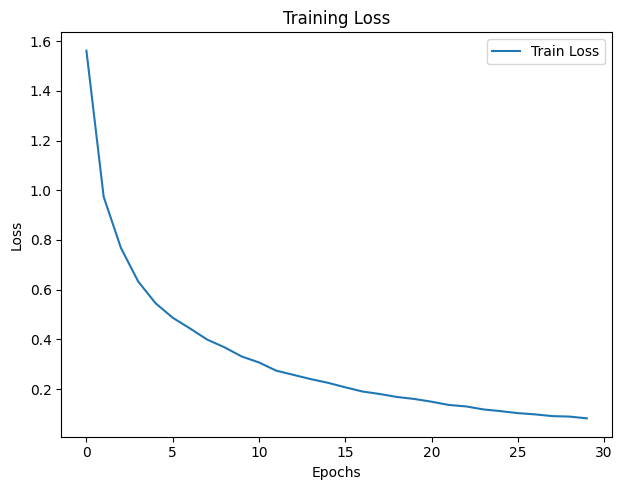

In [ ]:
import matplotlib.pyplot as plt
train_loss_history = [1.562, 0.974, 0.768, 0.633, 0.546, 0.487, 0.444, 0.399, 0.368, 0.331, 0.307, 0.274, 0.257, 0.240, 0.225, 0.207, 0.190, 0.180, 0.168, 0.160, 0.149, 0.136, 0.130, 0.118, 0.111, 0.103, 0.098, 0.091, 0.089, 0.082]
test_accuracy_history = []
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# save model
torch.save(model.state_dict(), 'ModifiedResNet.pth')

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# unpickle function
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# load
test_data_dict = unpickle('/content/drive/My Drive/Colab Notebooks/cifar_test_nolabels.pkl')
test_images = test_data_dict[b'data']
test_ids = test_data_dict[b'ids']

# transform
test_images = test_images.reshape(len(test_images), 3, 32, 32).transpose(0, 2, 3, 1)

# preprocess
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_images = torch.stack([transform(img) for img in test_images])

# data loader
test_loader = DataLoader(TensorDataset(test_images, torch.tensor(test_ids)), batch_size=64, shuffle=False)

# load model
model = model.to(device)
model.eval()

# predict
predicted_labels = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predicted_labels.extend(preds.cpu().numpy())

# generate CSV
submission_df = pd.DataFrame({
    'ID': test_ids,
    'Labels': predicted_labels
})
submission_df.to_csv('submission.csv', index=False)


Using device: cuda
